In [378]:
import requests
import time 
import pandas as pd
 
from bs4 import BeautifulSoup

In [379]:
electro_url = "https://www.ss.com/lv/transport/cars/electric-cars/sell/"

In [380]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

# lets make a function from the above doodle and make it work on most pages on SS
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

def getRow(row,colist):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

# so if we know how to work on single row then we can do process multiple rows
def getRows(rowlist,colist):
    return [getRow(row, colist=colist) for row in rowlist] # so return a list of dictionaries

# so with this function I can get full dataframe from a single page on ss.com not only apartments
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found, teiksim Bolderājai...
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"}) # find finds first match only
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice! to avoid rate limit or IP ban!!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df

In [381]:
df = get_all_ads_df(electro_url)

Last page is 6
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/page2.html
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/page3.html
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/page4.html
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/page5.html
Gathering data from https://www.ss.com/lv/transport/cars/electric-cars/sell/page6.html


In [382]:
df

,description,url,Marka,Gads,Nobrauk.,Cena
0,"Auto ar mazu nobraukumu. Navigācija, atpakaļsk...",https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2011,47 tūkst.,"9,990 €"
1,Только пригнан и Норвегии и в Латвии абсолютно...,https://ss.com/msg/lv/transport/cars/electric-...,NissanLeaf,2013,96 tūkst.,"8,750 €"
2,Tesla / Model 3 / Sr+ / 2021 \r\n\r\nLfp bater...,https://ss.com/msg/lv/transport/cars/electric-...,TeslaModel 3 sr+,2021,37 tūkst.,"44,600 €"
3,BMW iX3 Premier Edition Pro 210kW\r\nMineral-W...,https://ss.com/msg/lv/transport/cars/bmw/x3/cb...,BmwX3,2021,31 tūkst.,"68,900 €"
4,Pārdod Mercedes-Benz Eqc 400 4Matic Amg. Merce...,https://ss.com/msg/lv/transport/cars/electric-...,Mercedes-BenzEqc 400 4matic,2021,14 tūkst.,"75,000 €"
...,...,...,...,...,...,...
17,Audi Etron. Ražotāja garantija. \r\nAuto pirkt...,https://ss.com/msg/lv/transport/cars/audi/e-tr...,AudiE-tron,2020,23 tūkst.,"66,800 €"
18,Jauns Kia Ev6 2022. Cena ar Pvn. \r\n\r\nIespē...,https://ss.com/msg/lv/transport/cars/kia/anoth...,KiaAnother,2022,2 tūkst.,"52,900 €"
19,Ļoti kopta viena saimnieka mašīna. \r\nAkumula...,https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2013,97 tūkst.,"10,500 €"
20,"Hyundai Ioniq Electric (Jauns Auto), Premium (...",https://ss.com/msg/lv/transport/cars/hyundai/i...,HyundaiIoniq,2022,30,"34,500 €"


In [383]:
print(df.dtypes)

description    object
url            object
Marka          object
Gads           object
Nobrauk.       object
Cena           object
dtype: object


In [384]:
#type("Gads")

In [385]:
#df["Gads"] = pd.to_numeric(df["Gads"])

In [386]:
#print(df.dtypes)

In [387]:
df['Cena'] = df['Cena'].map(lambda x: str(x)[:-2])

df

,description,url,Marka,Gads,Nobrauk.,Cena
0,"Auto ar mazu nobraukumu. Navigācija, atpakaļsk...",https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2011,47 tūkst.,"9,990"
1,Только пригнан и Норвегии и в Латвии абсолютно...,https://ss.com/msg/lv/transport/cars/electric-...,NissanLeaf,2013,96 tūkst.,"8,750"
2,Tesla / Model 3 / Sr+ / 2021 \r\n\r\nLfp bater...,https://ss.com/msg/lv/transport/cars/electric-...,TeslaModel 3 sr+,2021,37 tūkst.,"44,600"
3,BMW iX3 Premier Edition Pro 210kW\r\nMineral-W...,https://ss.com/msg/lv/transport/cars/bmw/x3/cb...,BmwX3,2021,31 tūkst.,"68,900"
4,Pārdod Mercedes-Benz Eqc 400 4Matic Amg. Merce...,https://ss.com/msg/lv/transport/cars/electric-...,Mercedes-BenzEqc 400 4matic,2021,14 tūkst.,"75,000"
...,...,...,...,...,...,...
17,Audi Etron. Ražotāja garantija. \r\nAuto pirkt...,https://ss.com/msg/lv/transport/cars/audi/e-tr...,AudiE-tron,2020,23 tūkst.,"66,800"
18,Jauns Kia Ev6 2022. Cena ar Pvn. \r\n\r\nIespē...,https://ss.com/msg/lv/transport/cars/kia/anoth...,KiaAnother,2022,2 tūkst.,"52,900"
19,Ļoti kopta viena saimnieka mašīna. \r\nAkumula...,https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2013,97 tūkst.,"10,500"
20,"Hyundai Ioniq Electric (Jauns Auto), Premium (...",https://ss.com/msg/lv/transport/cars/hyundai/i...,HyundaiIoniq,2022,30,"34,500"


In [388]:
df['Cena'] = df['Cena'].replace(",","", regex=True)
df

,description,url,Marka,Gads,Nobrauk.,Cena
0,"Auto ar mazu nobraukumu. Navigācija, atpakaļsk...",https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2011,47 tūkst.,9990
1,Только пригнан и Норвегии и в Латвии абсолютно...,https://ss.com/msg/lv/transport/cars/electric-...,NissanLeaf,2013,96 tūkst.,8750
2,Tesla / Model 3 / Sr+ / 2021 \r\n\r\nLfp bater...,https://ss.com/msg/lv/transport/cars/electric-...,TeslaModel 3 sr+,2021,37 tūkst.,44600
3,BMW iX3 Premier Edition Pro 210kW\r\nMineral-W...,https://ss.com/msg/lv/transport/cars/bmw/x3/cb...,BmwX3,2021,31 tūkst.,68900
4,Pārdod Mercedes-Benz Eqc 400 4Matic Amg. Merce...,https://ss.com/msg/lv/transport/cars/electric-...,Mercedes-BenzEqc 400 4matic,2021,14 tūkst.,75000
...,...,...,...,...,...,...
17,Audi Etron. Ražotāja garantija. \r\nAuto pirkt...,https://ss.com/msg/lv/transport/cars/audi/e-tr...,AudiE-tron,2020,23 tūkst.,66800
18,Jauns Kia Ev6 2022. Cena ar Pvn. \r\n\r\nIespē...,https://ss.com/msg/lv/transport/cars/kia/anoth...,KiaAnother,2022,2 tūkst.,52900
19,Ļoti kopta viena saimnieka mašīna. \r\nAkumula...,https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2013,97 tūkst.,10500
20,"Hyundai Ioniq Electric (Jauns Auto), Premium (...",https://ss.com/msg/lv/transport/cars/hyundai/i...,HyundaiIoniq,2022,30,34500


In [389]:
print(df.dtypes)

description    object
url            object
Marka          object
Gads           object
Nobrauk.       object
Cena           object
dtype: object


In [390]:
df["Cena"] = pd.to_numeric(df["Cena"])
df

,description,url,Marka,Gads,Nobrauk.,Cena
0,"Auto ar mazu nobraukumu. Navigācija, atpakaļsk...",https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2011,47 tūkst.,9990
1,Только пригнан и Норвегии и в Латвии абсолютно...,https://ss.com/msg/lv/transport/cars/electric-...,NissanLeaf,2013,96 tūkst.,8750
2,Tesla / Model 3 / Sr+ / 2021 \r\n\r\nLfp bater...,https://ss.com/msg/lv/transport/cars/electric-...,TeslaModel 3 sr+,2021,37 tūkst.,44600
3,BMW iX3 Premier Edition Pro 210kW\r\nMineral-W...,https://ss.com/msg/lv/transport/cars/bmw/x3/cb...,BmwX3,2021,31 tūkst.,68900
4,Pārdod Mercedes-Benz Eqc 400 4Matic Amg. Merce...,https://ss.com/msg/lv/transport/cars/electric-...,Mercedes-BenzEqc 400 4matic,2021,14 tūkst.,75000
...,...,...,...,...,...,...
17,Audi Etron. Ražotāja garantija. \r\nAuto pirkt...,https://ss.com/msg/lv/transport/cars/audi/e-tr...,AudiE-tron,2020,23 tūkst.,66800
18,Jauns Kia Ev6 2022. Cena ar Pvn. \r\n\r\nIespē...,https://ss.com/msg/lv/transport/cars/kia/anoth...,KiaAnother,2022,2 tūkst.,52900
19,Ļoti kopta viena saimnieka mašīna. \r\nAkumula...,https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2013,97 tūkst.,10500
20,"Hyundai Ioniq Electric (Jauns Auto), Premium (...",https://ss.com/msg/lv/transport/cars/hyundai/i...,HyundaiIoniq,2022,30,34500


In [391]:
print(df.dtypes)

description    object
url            object
Marka          object
Gads           object
Nobrauk.       object
Cena            int64
dtype: object


In [392]:
df['Nobrauk.'] = df['Nobrauk.'].replace(" tūkst.","000", regex=True)
df

,description,url,Marka,Gads,Nobrauk.,Cena
0,"Auto ar mazu nobraukumu. Navigācija, atpakaļsk...",https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2011,47000,9990
1,Только пригнан и Норвегии и в Латвии абсолютно...,https://ss.com/msg/lv/transport/cars/electric-...,NissanLeaf,2013,96000,8750
2,Tesla / Model 3 / Sr+ / 2021 \r\n\r\nLfp bater...,https://ss.com/msg/lv/transport/cars/electric-...,TeslaModel 3 sr+,2021,37000,44600
3,BMW iX3 Premier Edition Pro 210kW\r\nMineral-W...,https://ss.com/msg/lv/transport/cars/bmw/x3/cb...,BmwX3,2021,31000,68900
4,Pārdod Mercedes-Benz Eqc 400 4Matic Amg. Merce...,https://ss.com/msg/lv/transport/cars/electric-...,Mercedes-BenzEqc 400 4matic,2021,14000,75000
...,...,...,...,...,...,...
17,Audi Etron. Ražotāja garantija. \r\nAuto pirkt...,https://ss.com/msg/lv/transport/cars/audi/e-tr...,AudiE-tron,2020,23000,66800
18,Jauns Kia Ev6 2022. Cena ar Pvn. \r\n\r\nIespē...,https://ss.com/msg/lv/transport/cars/kia/anoth...,KiaAnother,2022,2000,52900
19,Ļoti kopta viena saimnieka mašīna. \r\nAkumula...,https://ss.com/msg/lv/transport/cars/nissan/le...,NissanLeaf,2013,97000,10500
20,"Hyundai Ioniq Electric (Jauns Auto), Premium (...",https://ss.com/msg/lv/transport/cars/hyundai/i...,HyundaiIoniq,2022,30,34500


In [393]:
#df["Nobrauk."] = pd.to_numeric(df["Nobrauk."]) - šeit varētu mēģināt atrast kā ignorēt tos datus, kur ir "-", nedzēšot ārā

In [394]:
#df2 = df.groupby('Marka').sum()
df2 = df.groupby('Marka').agg({'Cena':['mean','median','min','max','count']})
df2

Cena                             
                           mean   median    min    max count
Marka                                                       
AudiE-Tron 55      73000.000000  73000.0  73000  73000     1
AudiE-tron         74915.000000  71990.0  66800  88880     4
BMW II3S           28500.000000  28500.0  28500  28500     1
BMWI3              24383.333333  26100.0  16000  32900     6
BMWI3 120A         28500.000000  28500.0  28500  28500     1
...                         ...      ...    ...    ...   ...
VwE-Up             19800.000000  19800.0  14900  24700     2
VwEup              13400.000000  13400.0  13400  13400     1
VwId4              51250.000000  51250.0  51250  51250     1
ŠkodaEnyaq         59900.000000  59900.0  59900  59900     1
ŠkodaEnyaq iv 80x  73500.000000  73500.0  73500  73500     1

[81 rows x 5 columns]

In [395]:
df3 = df.groupby('Gads').agg({'Cena':['mean','median','min','max','count']})
df3

Cena                              
              mean   median    min     max count
Gads                                            
2008   3800.000000   3800.0   3800    3800     1
2011   7995.000000   7745.0   6500    9990     4
2012   6313.333333   6400.0   4950    7590     3
2013  12060.000000   9990.0   8750   29000    12
2014  17417.500000  17445.0   9350   32000     8
2015  22357.000000  19050.0  13850   56000    10
2016  31567.500000  19325.0  14900   69990     8
2017  26569.000000  23700.0  15650   69950    10
2018  31037.500000  27300.0  24500   60000     8
2019  33628.333333  31950.0  22500   55000    18
2020  41980.869565  27900.0   5500  147900    23
2021  51364.857143  51990.0  11600   85900    35
2022  66573.593750  66250.0  34000  111000    32

In [396]:

df4 = df.groupby('Marka').agg({'Gads':['median','min','max','count']})

df4

Gads                  
                   median   min   max count
Marka                                      
AudiE-Tron 55      2020.0  2020  2020     1
AudiE-tron         2020.5  2020  2022     4
BMW II3S           2018.0  2018  2018     1
BMWI3              2017.5  2013  2019     6
BMWI3 120A         2018.0  2018  2018     1
...                   ...   ...   ...   ...
VwE-Up             2018.5  2016  2021     2
VwEup              2014.0  2014  2014     1
VwId4              2021.0  2021  2021     1
ŠkodaEnyaq         2021.0  2021  2021     1
ŠkodaEnyaq iv 80x  2022.0  2022  2022     1

[81 rows x 4 columns]

<AxesSubplot: >

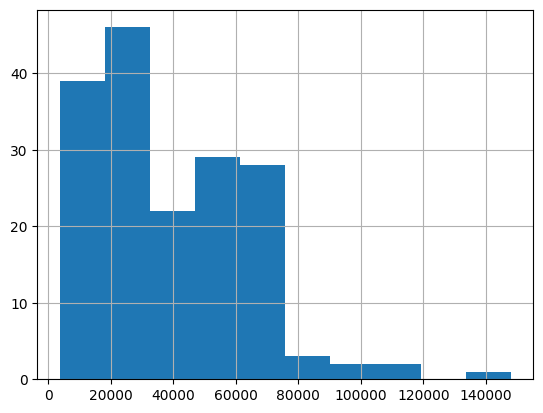

In [397]:
df.Cena.hist()

#hist.xlabel("Age")
#hist.ylabel("Individuals")

#ax.set_xlabel("Prices")
#ax.set_ylabel("Car_count")